# THE MUSIC MAKER WITH LSTM NEURAL NETWORKS. (Part 1)

Author: Matt Mills; MANTIS project. The purpose of this notebook is to show you how to implement machine learning when time series related data is involved. A nice goto example is that of music from a midi file. If we provide a stream of music to a neural network poised to handling time series data (e.g. RNN), this data should be able to train a network such that it draws patterns in the time series data. Then, the trained network can be used to predict new music. Although generating music is far removed from the goals of MANTIS, the skillsets of learning how to use time series neural nets is definitely applicable; generating music just so happens to have prior community activity in TensorFlow and Keras

# Table of Contents
1. [Import and Path Setups](#first-section)
2. [Loading songs with music21](#second-section)
3. [Modeling with a LSTM neural network](#third-section)
4. [Predicting new music with LSTM neural network](#fourth-section)

## Import and Path Setups <a class = "anchor" id = "first-section"></a> 

Make sure you can import the following. You may want to check out what music21, tensorflow, and keras are if you are new to them.

In [2]:
from music21 import *
import numpy as np
import os
import sys
import tensorflow as tf
import keras
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import ModelCheckpoint

music21: Certain music21 functions might need the optional package matplotlib;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html
Using TensorFlow backend.


Check to see if your paths are all correct. Getting paths initially set can be like feeding your hand to a wood chipper if you've never done it before. Ask Matt, Eric, or Eleanor if you have trouble. Make a music21 enviornment and get the different keys. These are used to connect programs to music21 such as musescore which prints out scores. TL;DR: verify working path is correct and make sure music21 knows what musescore is.

In [7]:
print(os.getcwd())
print(sys.path)

/home/millsms/Code/MattsMusicMaker
['/home/millsms/anaconda3/lib/python36.zip', '/home/millsms/anaconda3/lib/python3.6', '/home/millsms/anaconda3/lib/python3.6/lib-dynload', '', '/home/millsms/.local/lib/python3.6/site-packages', '/home/millsms/anaconda3/lib/python3.6/site-packages', '/home/millsms/.local/lib/python3.6/site-packages/IPython/extensions', '/home/millsms/.ipython']


In [8]:
e = environment.Environment()
for key in sorted(e.getKeysToPaths()):
    print(key)

braillePath
graphicsPath
lilypondPath
localCorpusPath
manualCoreCorpusPath
midiPath
musescoreDirectPNGPath
musicxmlPath
pdfPath
vectorPath


In [9]:
e['musicxmlPath'] ='/usr/bin/musescore'
e['musescoreDirectPNGPath'] = '/usr/bin/musescore'

## Loading songs with music21 <a class = "anchor" id = "second-section"></a>

Now we are all set to play with the music21. This program is pretty awesome, it'll take songs and organize them using music21 objects which contain a whole host of relevant things to music like tone, pitch, measures, clefs, octave, chords, that kind of jazz. I don't know too much about music, but I know it is a lot more than just notes and music21 will let us access this kind of stuff. Consult music21 API for all the stuff

Anyway. Let's make a note

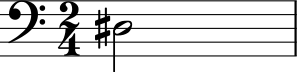

In [5]:
n = note.Note("D#3")
n.duration.type = 'half'
n.show()

We can also make a stream of notes using the parser and play the result.  

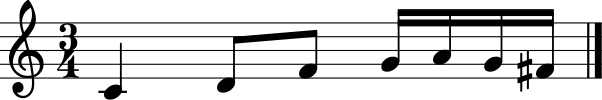

In [6]:
littleMelody = converter.parse("tinynotation: 3/4 c4 d8 f g16 a g f#")
littleMelody.show()

In [7]:
littleMelody.show('midi')


Let's now not manually put in music, but instead convert a midi file to a score object. This is a subclass of stream which handles multi-part music.  Let's use a megaman song - note that there are four parts.

In [8]:
myScore = converter.parse('MegaManMidi/metal-man.mid')
print(myScore)
print(myScore.classes)

<music21.stream.Score 0x7f700b974668>
('Score', 'Stream', 'StreamCoreMixin', 'Music21Object', 'object')


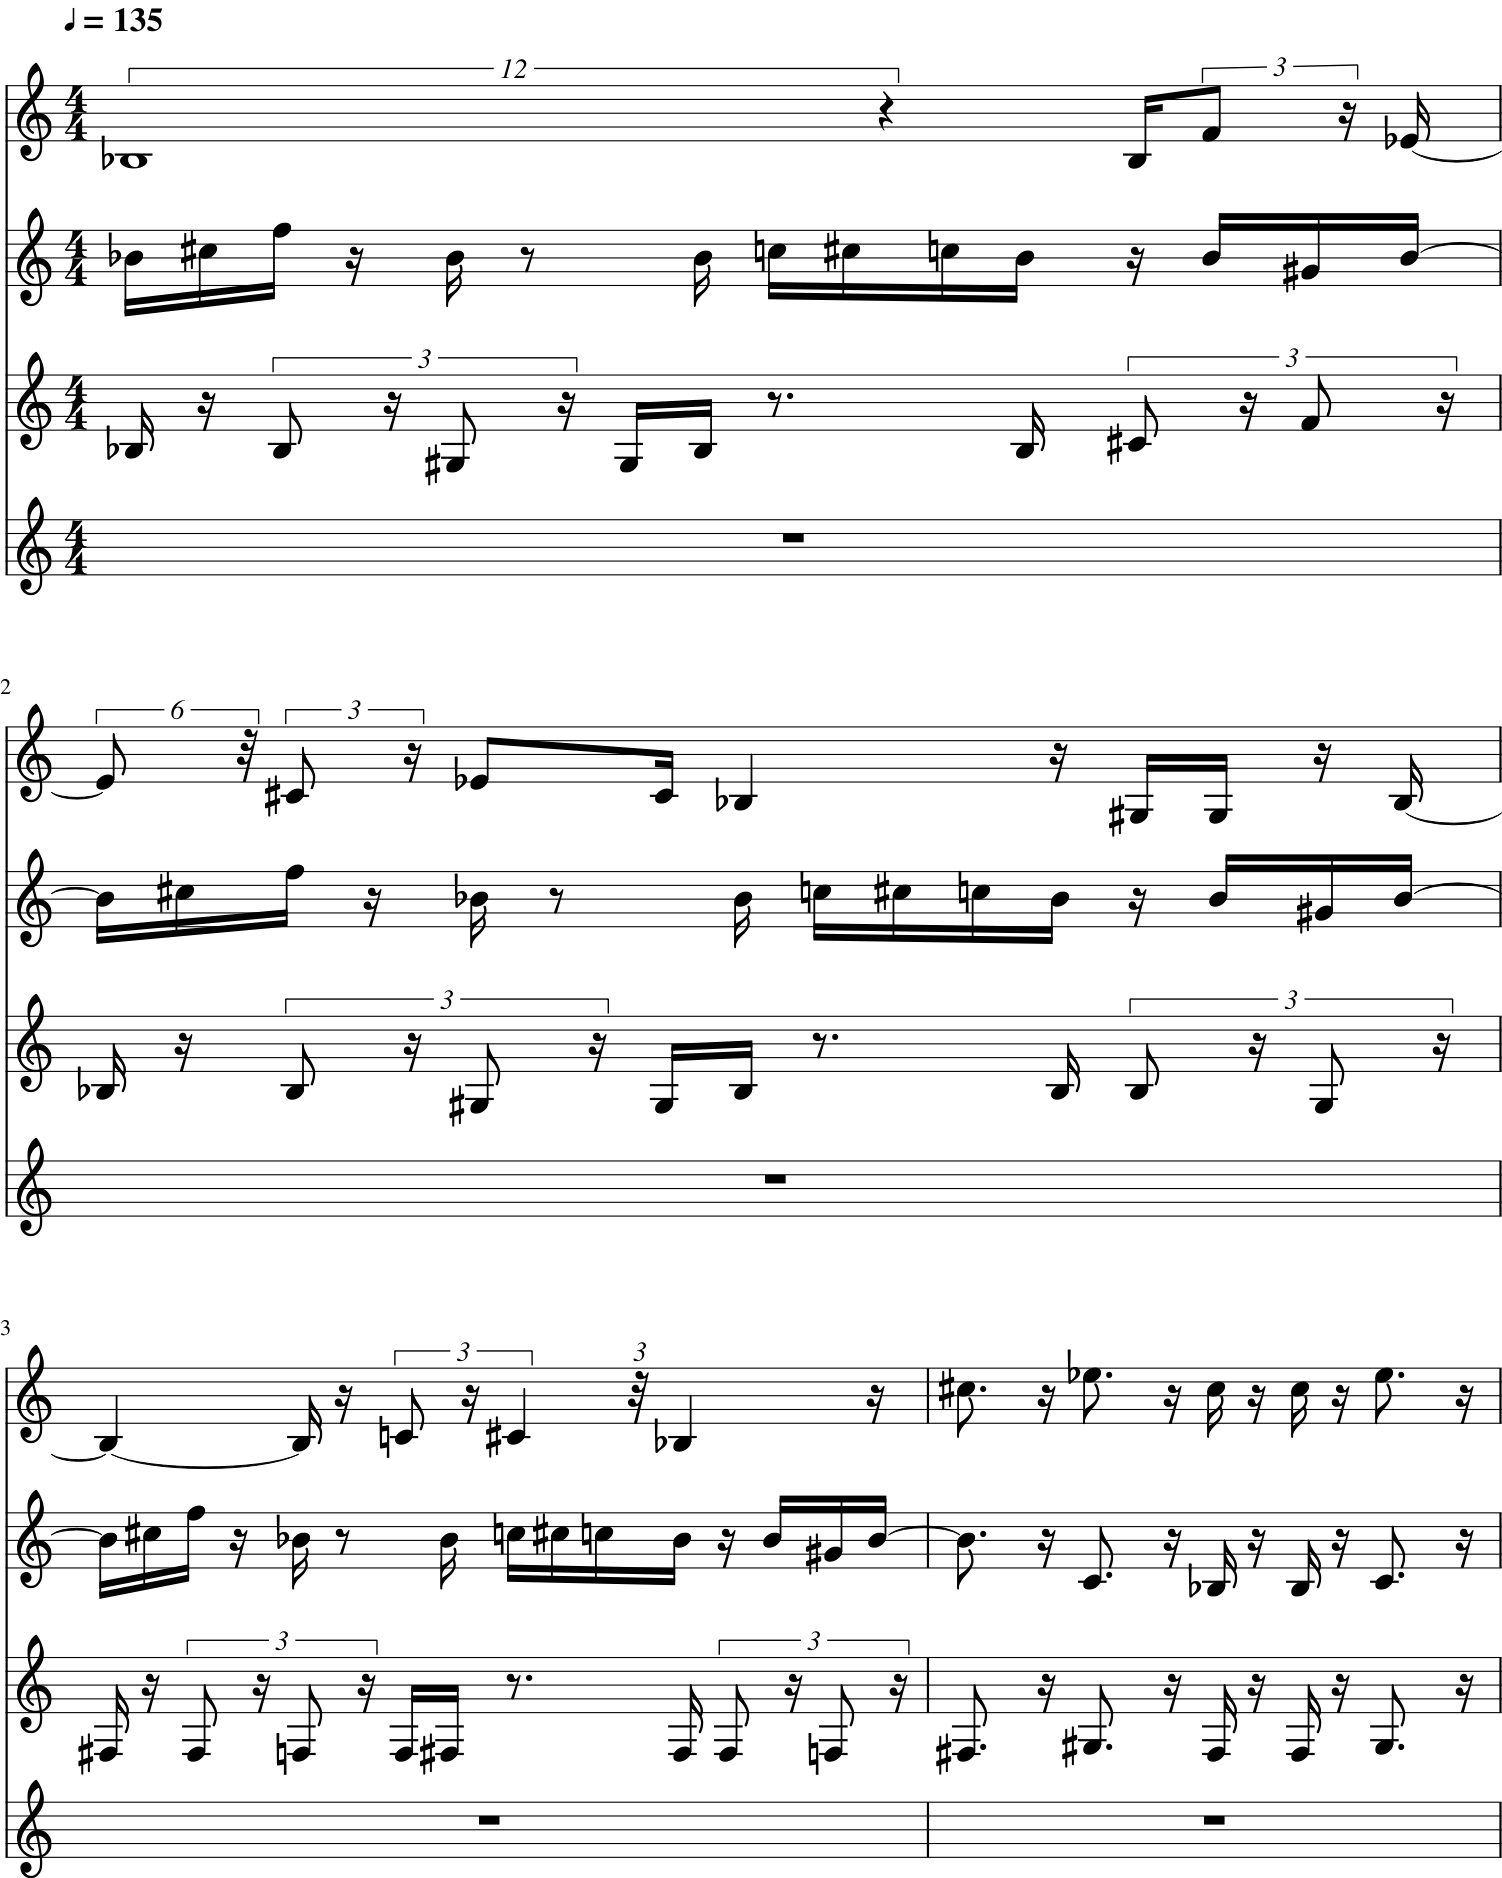

In [9]:
myScore.show()
myScore.show('midi')

Brings back some memories of Christmas when I first got megaman 2. Let me say that this midi file is definitely not the original song which [sounds like this](https://www.youtube.com/watch?v=si8HiBgcg_U) but Midi files are much simpler to deal with so we intially will just use them. Perhaps later on we can expand to more complex sound file types. 

Midi files can contain multiple instruments. Let's just take the piano (which in this song case, that is the only instrument) and print out all the music stuff in there.

In [10]:
myScoreParts = instrument.partitionByInstrument(myScore)

if myScoreParts: #More than one instrument
    notes_to_parse = myScoreParts.parts[0].recurse() #takes first instrument
else:
    notes_to_parse = myScoreParts.flat.notes

print(notes_to_parse)
for notes in notes_to_parse:
    print(notes)

<music21.stream.iterator.RecursiveIterator for Part:None @:0>

<music21.tempo.MetronomeMark Quarter=135.0>
<music21.meter.TimeSignature 4/4>
<music21.meter.TimeSignature 4/4>
<music21.meter.TimeSignature 4/4>
<music21.meter.TimeSignature 4/4>
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Rest rest>
<music21.note.Note C#>
<music21.note.Rest rest>
<music21.note.Note F>
<music21.note.Note B->
<music21.note.Rest rest>
<music21.note.Rest rest>
<music21.note.Note B->
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Rest rest>
<music21.note.Note C#>
<music21.note.Rest rest>
<music21.note.Note C>
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Rest rest>
<music21.note.Note C#>
<music21.note.Note F>
<music21.note.Note B->
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Note F>
<music

Ok, so notes_to_parse is the collection of notes, rests, time signitures, and offsets that make up the midi file. Let's collect only notes and chords for now and put them in string form.

In [114]:
print(notes_to_parse[14].duration.type)
dir(notes_to_parse[14])


16th


['_DOC_ATTR',
 '_DOC_ORDER',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activeSite',
 '_activeSiteStoredOffset',
 '_classListFullyQualifiedCacheDict',
 '_classSetCacheDict',
 '_classTupleCacheDict',
 '_deepcopySubclassable',
 '_derivation',
 '_duration',
 '_editorial',
 '_getActiveSite',
 '_getDerivation',
 '_getDuration',
 '_getLyric',
 '_getMeasureOffset',
 '_getOffset',
 '_getPriority',
 '_getQuarterLength',
 '_getSeconds',
 '_getTimeSignatureForBeat',
 '_naiveOffset',
 '_priority',
 '_reprText',
 '_reprTextLine',
 '_setActiveSite',
 '_setDerivation',
 '_setDuration',
 '_setLyric',
 '_setOffset',
 '_setPriori

In [117]:
notesFull = []
for element in notes_to_parse:
    if isinstance(element, note.Note):
        notesFull.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
        notesFull.append('.'.join(str(n) for n in element.normalOrder))

Now our notes are in a list and no longer a music21 object. 

In [12]:
print(notesFull)

['B-3', 'B-4', 'B-3', 'C#5', 'F5', 'B-3', 'B-4', 'G#3', 'G#3', 'B-4', 'B-3', 'C5', 'C#5', 'C5', 'B-4', 'B-3', 'B-3', 'C#4', 'F4', 'B-4', 'G#4', 'F4', 'E-4', 'B-4', 'B-3', 'C#5', 'C#4', 'F5', 'B-3', 'E-4', 'B-4', 'G#3', 'C#4', 'G#3', 'B-3', 'B-4', 'B-3', 'C5', 'C#5', 'C5', 'B-4', 'B-3', 'G#3', 'B-3', 'G#3', 'B-4', 'G#4', 'G#3', 'B-3', 'B-4', 'F#3', 'C#5', 'F5', 'F#3', 'B-4', 'F3', 'C4', 'F3', 'B-4', 'F#3', 'C#4', 'C5', 'C#5', 'C5', 'B-3', 'B-4', 'F#3', 'F#3', 'B-4', 'G#4', 'F3', 'B-4', 'C#5', 'F#3', 'E-5', 'C4', 'G#3', 'C#5', 'B-3', 'F#3', 'C#5', 'B-3', 'F#3', 'E-5', 'C4', 'G#3', 'B-3', 'B-4', 'B-3', 'C#5', 'F5', 'B-3', 'B-4', 'G#3', 'G#3', 'B-4', 'B-3', 'C5', 'C#5', 'C5', 'B-3', 'B-4', 'B-3', 'C#4', 'F4', 'B-4', 'F4', 'G#4', 'E-4', 'B-4', 'B-3', 'C#5', 'C#4', 'F5', 'B-3', 'E-4', 'B-4', 'G#3', 'C#4', 'G#3', 'B-3', 'B-4', 'B-3', 'C5', 'C#5', 'C5', 'B-4', 'B-3', 'G#3', 'B-3', 'G#3', 'B-4', 'G#4', 'G#3', 'B-3', 'B-4', 'F#3', 'C#5', 'F5', 'F#3', 'B-4', 'F3', 'C4', 'F3', 'B-4', 'F#3', 'C#4',

Great, we now have a list containing all the notes and chords, notice how we have a string which consists of a pitch and an octave so E-4 is E Flat pitch and 4th octave.

We also have a lot of notes as the midi song can be several minutes long. We can cut down the song time as an option by only taking the first k notes

The next thing to do, is make this into a form that a neural network can consume. This is most easily done by some sort of encoding which is just assigning a number to each type of note/chord. We have a lot of repeats, so let's just look at the total set of notes that appear and sort them alphabetically. 

In [13]:
print(len(notesFull))
notes = notesFull[:500] # Use the first 500 notes of the song
pitchList = sorted(set(item for item in notes))
print(pitchList)

2093
['A3', 'A4', 'B-3', 'B-4', 'C#4', 'C#5', 'C4', 'C5', 'E-4', 'E-5', 'F#3', 'F3', 'F4', 'F5', 'G#3', 'G#4']


Now create a dictionary where the key is the note and assign a number to it.

In [14]:
note2Int = dict((note, number) for number, note in enumerate(pitchList))
print(note2Int)

{'A3': 0, 'A4': 1, 'B-3': 2, 'B-4': 3, 'C#4': 4, 'C#5': 5, 'C4': 6, 'C5': 7, 'E-4': 8, 'E-5': 9, 'F#3': 10, 'F3': 11, 'F4': 12, 'F5': 13, 'G#3': 14, 'G#4': 15}


Ok, now we have a way of encoding a number value to a note. The next step is to do what is done in LSTM RNN, that is have a sequence of notes as the input and the ouput is then the VERY next note that follows the input sequence. This is the xtrain and ytrain data. Make sure the length of x_train notes is reasonable to the total number of notes in the song. If you have 2000 total notes, maybe 100 is good for sequence length

In [15]:
network_input = []
network_output = []

In [16]:
seq_length = 100

for i in range(0, len(notes) - seq_length - 1, 1): # Take all sets of k notes as input and store the k+1 as output
    seq_in = notes[i:i + seq_length] # k notes
    seq_out = notes[i + seq_length + 1] # k+1 note
    network_input.append([note2Int[n] for n in seq_in]) # Convert to number and store input
    network_output.append(note2Int[seq_out]) # Convert to number and store output


Notice that we have the same amount of data for input and output, except that each input is a collection of k notes correlated to a single output note. Also, we reshape the input so that it is consumable by Keras.

In [17]:
print(len(network_input)) 
print(len(network_output))
print(network_input[0])
print(network_output[0])

399
399
[2, 3, 2, 5, 13, 2, 3, 14, 14, 3, 2, 7, 5, 7, 3, 2, 2, 4, 12, 3, 15, 12, 8, 3, 2, 5, 4, 13, 2, 8, 3, 14, 4, 14, 2, 3, 2, 7, 5, 7, 3, 2, 14, 2, 14, 3, 15, 14, 2, 3, 10, 5, 13, 10, 3, 11, 6, 11, 3, 10, 4, 7, 5, 7, 2, 3, 10, 10, 3, 15, 11, 3, 5, 10, 9, 6, 14, 5, 2, 10, 5, 2, 10, 9, 6, 14, 2, 3, 2, 5, 13, 2, 3, 14, 14, 3, 2, 7, 5, 7]
3


In [18]:
network_input = np.reshape(network_input, (len(network_input), seq_length, 1))
network_input.shape

(399, 100, 1)

We now normalize the networks to be [0,1]

In [19]:
network_input = network_input / float(len(pitchList))
network_output = tf.keras.utils.to_categorical(network_output)

So now if we re-print say the first element, we find the inputs are normalized. Furthermore, the output of say "3" is now in the vector form [0 0 0 1 0 ... ]. This is what the tensorflow categorical function does 

In [20]:
print(network_input[0])
print(network_output[0])

[[0.125 ]
 [0.1875]
 [0.125 ]
 [0.3125]
 [0.8125]
 [0.125 ]
 [0.1875]
 [0.875 ]
 [0.875 ]
 [0.1875]
 [0.125 ]
 [0.4375]
 [0.3125]
 [0.4375]
 [0.1875]
 [0.125 ]
 [0.125 ]
 [0.25  ]
 [0.75  ]
 [0.1875]
 [0.9375]
 [0.75  ]
 [0.5   ]
 [0.1875]
 [0.125 ]
 [0.3125]
 [0.25  ]
 [0.8125]
 [0.125 ]
 [0.5   ]
 [0.1875]
 [0.875 ]
 [0.25  ]
 [0.875 ]
 [0.125 ]
 [0.1875]
 [0.125 ]
 [0.4375]
 [0.3125]
 [0.4375]
 [0.1875]
 [0.125 ]
 [0.875 ]
 [0.125 ]
 [0.875 ]
 [0.1875]
 [0.9375]
 [0.875 ]
 [0.125 ]
 [0.1875]
 [0.625 ]
 [0.3125]
 [0.8125]
 [0.625 ]
 [0.1875]
 [0.6875]
 [0.375 ]
 [0.6875]
 [0.1875]
 [0.625 ]
 [0.25  ]
 [0.4375]
 [0.3125]
 [0.4375]
 [0.125 ]
 [0.1875]
 [0.625 ]
 [0.625 ]
 [0.1875]
 [0.9375]
 [0.6875]
 [0.1875]
 [0.3125]
 [0.625 ]
 [0.5625]
 [0.375 ]
 [0.875 ]
 [0.3125]
 [0.125 ]
 [0.625 ]
 [0.3125]
 [0.125 ]
 [0.625 ]
 [0.5625]
 [0.375 ]
 [0.875 ]
 [0.125 ]
 [0.1875]
 [0.125 ]
 [0.3125]
 [0.8125]
 [0.125 ]
 [0.1875]
 [0.875 ]
 [0.875 ]
 [0.1875]
 [0.125 ]
 [0.4375]
 [0.3125]
 [0.4375]]

## Modeling with a LSTM neural network <a class = "anchor" id = "third-section"></a>

Equiped now with a series of input notes that have been decoded to numbers (and can be encoded back to notes later on) and output notes which are correlated to the previous k notes which have also been decoded to numbers, we can set up our neural network. We begin by defining a new keras model

In [21]:
model = Sequential()
print(network_input.shape)
print(network_output.shape)

(399, 100, 1)
(399, 16)


Keras now makes it easy to add in neural network layers. We wish to use LSTM for our time series problem. I encourage you to read up more on LSTM and why it is appropriate for these types of problems. In general though, this machine learning setup can invoke any number of different types of models.

LSTM layers is a Recurrent Neural Net layer that takes a sequence as an input and can return either sequences (return_sequences=True) or a matrix.

Dropout layers are a regularisation technique that consists of setting a fraction of input units to 0 at each update during the training to prevent overfitting. The fraction is determined by the parameter used with the layer.

Dense layers or fully connected layers is a fully connected neural network layer where each input node is connected to each output node.

The Activation layer determines what activation function our neural network will use to calculate the output of a node.

In [22]:
model.add(LSTM(
    256,
    input_shape = (network_input.shape[1], network_input.shape[2]), # kx1 notes on input, tells network what to expect
    return_sequences = True
))
model.add(Dropout(0.3))   #These layers can be whatever, try different combinations
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(len(pitchList))) # Last layer needs to have same size as our ouputs
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')


Now that the model skeleton is setup let's train with the input and output values. <b> This step will take time </b>

In [88]:
outputpath = "MegaManWeights/w-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(
    outputpath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     

model.fit(network_input, network_output, epochs = 200, batch_size = 32, callbacks = callbacks_list)

Epoch 1/200
399/399 [==============================] - 8s 20ms/step - loss: 2.4532
Epoch 2/200
399/399 [==============================] - 8s 21ms/step - loss: 2.4563
Epoch 3/200
399/399 [==============================] - 8s 20ms/step - loss: 2.4295
Epoch 4/200
399/399 [==============================] - 8s 19ms/step - loss: 2.4397
Epoch 5/200
399/399 [==============================] - 8s 19ms/step - loss: 2.4332
Epoch 6/200
399/399 [==============================] - 8s 21ms/step - loss: 2.4025
Epoch 7/200
399/399 [==============================] - 8s 20ms/step - loss: 2.3947
Epoch 8/200
399/399 [==============================] - 8s 19ms/step - loss: 2.3510
Epoch 9/200
399/399 [==============================] - 8s 19ms/step - loss: 2.3539
Epoch 10/200
399/399 [==============================] - 8s 20ms/step - loss: 2.3549
Epoch 11/200
399/399 [==============================] - 8s 19ms/step - loss: 2.3334
Epoch 12/200
399/399 [==============================] - 8s 19ms/step - loss: 2.3366
E

KeyboardInterrupt: 

## Predicting new music with LSTM neural network <a class = "anchor" id = "fourth-section"></a>

We now have the neural network weights saved as binary files ending in .hdf5. We now just need to load them, then prime the neural network with a new set of inputs to see what it generates. We ideally want to do this in a new keras model so that we don't have to train in order to predict. Instead we can use the weights that we trained previously

In [89]:
predictmodel = Sequential()
predictmodel.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
predictmodel.add(Dropout(0.3))
predictmodel.add(LSTM(512, return_sequences=True))
predictmodel.add(Dropout(0.3))
predictmodel.add(LSTM(256))
predictmodel.add(Dense(256))
predictmodel.add(Dropout(0.3))
predictmodel.add(Dense(len(pitchList)))
predictmodel.add(Activation('softmax'))
predictmodel.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [90]:
predictmodel.load_weights('MegaManWeights/w-88.hdf5')

We are ready to predict. Let's start by randomly picking a note or chord in the network input 

In [91]:
start = np.random.randint(0, len(network_input) -1)
print(start)

352


In [92]:
pattern = network_input[start]
pattern = [item for sublist in pattern for item in sublist]
print(pattern)

[0.5, 0.3125, 0.5, 0.5625, 0.3125, 0.25, 0.5625, 0.375, 0.1875, 0.3125, 0.25, 0.1875, 0.3125, 0.25, 0.1875, 0.3125, 0.25, 0.9375, 0.4375, 0.375, 0.375, 0.1875, 0.3125, 0.25, 0.25, 0.1875, 0.5, 0.8125, 0.1875, 0.75, 0.8125, 0.5625, 0.5, 0.5, 0.5625, 0.25, 0.3125, 0.5, 0.3125, 0.25, 0.5, 0.4375, 0.5, 0.4375, 0.5, 0.3125, 0.5, 0.5625, 0.3125, 0.25, 0.8125, 0.5625, 0.375, 0.75, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.4375, 0.4375, 0.8125, 0.4375, 0.4375, 0.8125, 0.9375, 0.5625, 0.9375, 0.3125, 0.9375, 0.5625, 0.9375, 0.3125, 0.75, 0.4375, 0.75, 0.1875, 0.75, 0.9375, 0.75, 0.5625, 0.5, 0.5, 0.5625, 0.25, 0.3125, 0.5, 0.3125, 0.25, 0.5, 0.4375, 0.5, 0.4375, 0.5, 0.3125, 0.5, 0.5625, 0.3125, 0.25]


Before we had defined a note2Int for decoding, now we do the opposite to give us int2Note for encoding

In [93]:
int2Note = dict((number, note) for number, note in enumerate(pitchList))
print(int2Note)

{0: 'A3', 1: 'A4', 2: 'B-3', 3: 'B-4', 4: 'C#4', 5: 'C#5', 6: 'C4', 7: 'C5', 8: 'E-4', 9: 'E-5', 10: 'F#3', 11: 'F3', 12: 'F4', 13: 'F5', 14: 'G#3', 15: 'G#4'}


Now we will put this into the neural network which will return an output note. We will then append this note to the input and forget the most distant note and repeat

In [94]:
prediction_output = []
numNotes = 100

for note_index in range(numNotes):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(len(pitchList))

    prediction = predictmodel.predict(prediction_input, verbose=0)

    index = np.argmax(prediction)
    result = int2Note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In [95]:
prediction_output

['G#3',
 'G#3',
 'B-4',
 'B-3',
 'C5',
 'C#5',
 'F5',
 'B-4',
 'B-4',
 'F4',
 'F4',
 'F4',
 'F5',
 'E-4',
 'E-5',
 'C#4',
 'C#5',
 'E-4',
 'C#5',
 'C#4',
 'E-4',
 'C5',
 'C5',
 'C5',
 'E-4',
 'C#5',
 'E-4',
 'C#5',
 'C#5',
 'C#4',
 'F5',
 'E-5',
 'C4',
 'F5',
 'F5',
 'F5',
 'F5',
 'F5',
 'F5',
 'C5',
 'C5',
 'F5',
 'C5',
 'F5',
 'G#4',
 'G#4',
 'C#5',
 'G#4',
 'G#4',
 'C#5',
 'C#5',
 'C5',
 'B-4',
 'B-4',
 'B-4',
 'C5',
 'C5',
 'C5',
 'G#3',
 'E-4',
 'E-4',
 'B-3',
 'C#5',
 'F5',
 'F5',
 'B-4',
 'C5',
 'C5',
 'B-4',
 'C#4',
 'C#4',
 'C#4',
 'C#4',
 'C#4',
 'C#5',
 'C5',
 'C5',
 'C4',
 'E-4',
 'B-4',
 'B-4',
 'C#4',
 'C#4',
 'B-4',
 'E-4',
 'F5',
 'B-4',
 'F5',
 'E-5',
 'E-4',
 'E-5',
 'E-5',
 'C#5',
 'C#5',
 'E-4',
 'C#5',
 'C#4',
 'C5',
 'C5',
 'C5']

So now we have our notes and chords and just need to put them back into a music21 stream format and write the midi file and look at the Score.

In [96]:
offset = 0
output_notes = []

for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [3]:
fp='MegaManNNOutput/FirstTest.mid'
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp)

NameError: name 'output_notes' is not defined

In [4]:
midiNN = converter.parse(fp)

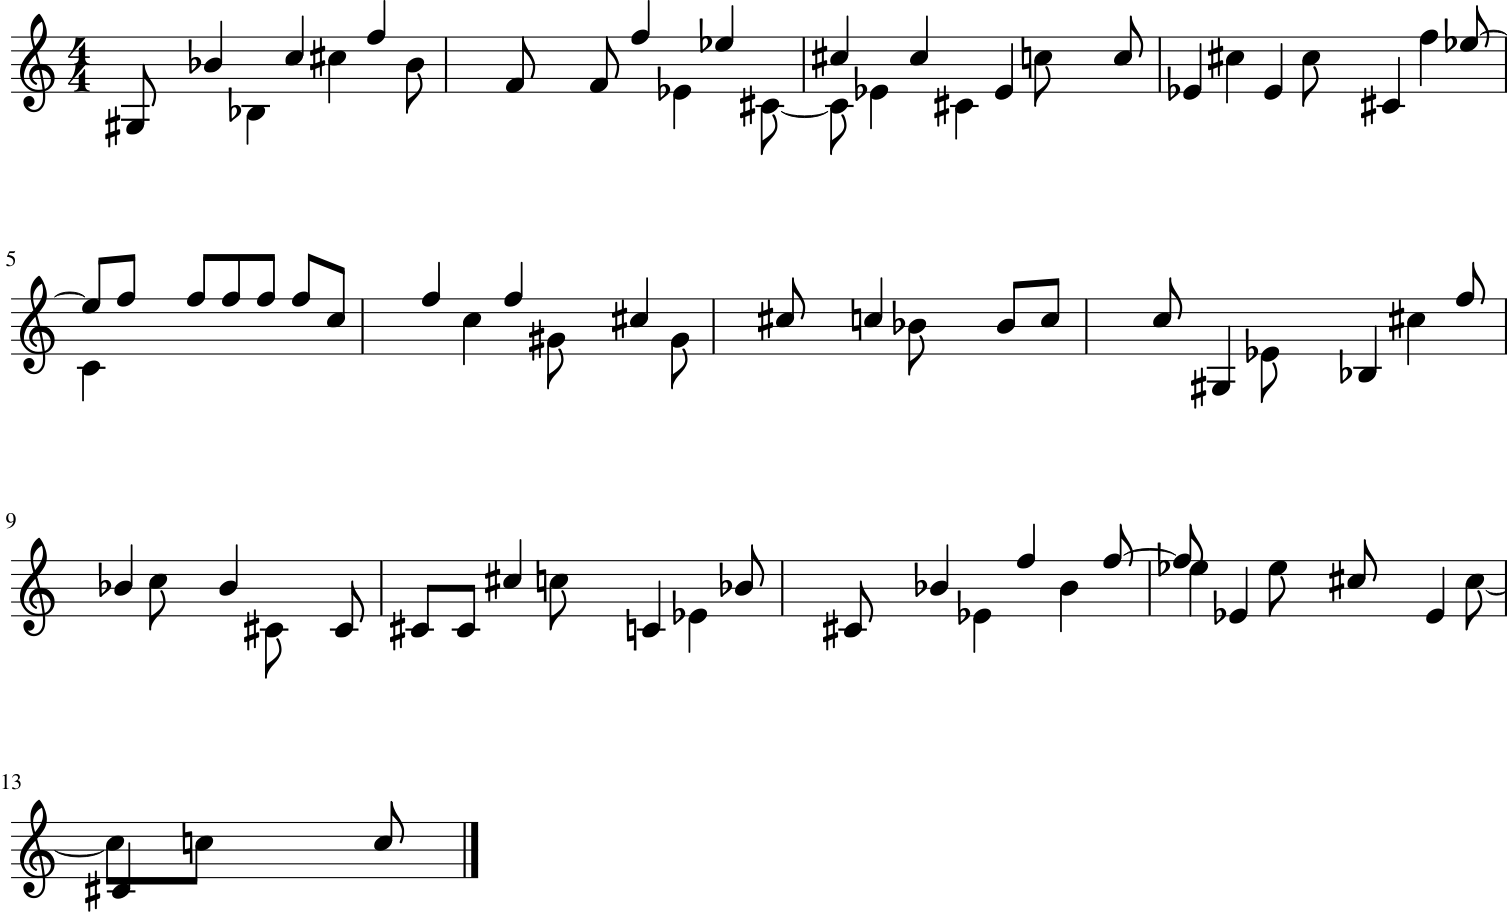

In [11]:
midiNN.show()
midiNN.show('midi')